## Evaluating


Cloning the repository:

In [1]:
!git clone https://github.com/katjakon/GurkLM.git -b dev2

Cloning into 'GurkLM'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 211 (delta 105), reused 181 (delta 85), pack-reused 0 (from 0)
Receiving objects: 100% (211/211), 431.31 KiB | 4.07 MiB/s, done.
Resolving deltas: 100% (105/105), done.


Next, we install necessary packages

In [2]:
!pip install datasets conllu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00


This is necessary to be able to import custom functions and classes.

In [3]:
import sys
sys.path.insert(0,'/content/GurkLM')

Mount the Google Drive, so we are able to import model checkpoints.

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import os
import json
from statistics import mean
import torch
from transformers import BertTokenizerFast, BertModel, AutoModelForMaskedLM
from tqdm import tqdm

from evaluate import save_metrics
from gurk.modules import FullModel
from gurk.classifier import UpperBoundClassifier, train_model
from gurk.ud_data import get_ud_data, get_code_mapping, get_pos_mapping
from gurk.masked_predict import accuracy_at_n, predict_masked_bert, predict_masked_gurk


In [5]:
# Some variable that are the same for all validation tasks
ud_ds = "qtd_sagt" # Identifier of Universal Dependencies data set
# We don't bother optimizing hyperparameters:
batch_size = 16
n_epochs = 5
lr = 0.001

Set device:

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Upper Bound Classifier
Here, we evaluate the performance of a pre-trained multilingual BERT model on the validation task

In [7]:
model_type = "google-bert/bert-base-multilingual-cased" # model to use as a base for upper bound clf.
result_dir = "result_mbert" # where to store results.


In [8]:
res_path = os.path.join("GurkLM", result_dir)
if not os.path.exists(res_path):
  os.mkdir(res_path)

In [33]:
tokenizer = BertTokenizerFast.from_pretrained(model_type)
model = BertModel.from_pretrained(model_type)

### Part-of-Speech Tagging
We investigate the performance on labeling words with part-of-speech tags.

In [31]:
train_pos_dl, val_pos_dl, test_pos_dl = get_ud_data(
  ud_ds,
  batch_size=batch_size,
  tokenizer=tokenizer,
  label_type="upos")


Map:   0%|          | 0/285 [00:00<?, ? examples/s]

Map:   0%|          | 0/801 [00:00<?, ? examples/s]

Map:   0%|          | 0/805 [00:00<?, ? examples/s]

In [34]:
dim = model.config.hidden_size
pos_classes = get_pos_mapping(train_pos_dl.dataset) # Mapping from class label to index
num_classes = len(pos_classes)

clf_nn = UpperBoundClassifier(num_classes, model, dim=dim)

# Train model.
logs = train_model(
clf_nn,
train_pos_dl,
val_pos_dl,
lr=lr,
n_epochs=n_epochs,
pad_token_id=tokenizer.pad_token_id
)



Validating...: 100%|██████████| 51/51 [00:09<00:00,  5.26it/s]


Train Loss: 33.351341247558594	 Train Accuracy 0.441340782122905
Val Loss: 57.55782341957092	 Val Accuracy 0.6889446472019465


Validating...: 100%|██████████| 51/51 [00:09<00:00,  5.12it/s]


Train Loss: 15.24239867925644	 Train Accuracy 0.7426029381336644
Val Loss: 38.730243146419525	 Val Accuracy 0.7679440389294404


Validating...: 100%|██████████| 51/51 [00:09<00:00,  5.31it/s]


Train Loss: 10.298819899559021	 Train Accuracy 0.8237119801365611
Val Loss: 35.0660397708416	 Val Accuracy 0.7829227493917275


Validating...: 100%|██████████| 51/51 [00:09<00:00,  5.41it/s]


Train Loss: 8.093910843133926	 Train Accuracy 0.8644734119594455
Val Loss: 32.88152316212654	 Val Accuracy 0.8058090024330901


Validating...: 100%|██████████| 51/51 [00:10<00:00,  5.05it/s]

Train Loss: 6.761876747012138	 Train Accuracy 0.8932340161390441
Val Loss: 34.50510799884796	 Val Accuracy 0.7967609489051095


Predicting..: 100%|██████████| 51/51 [00:02<00:00, 19.30it/s]


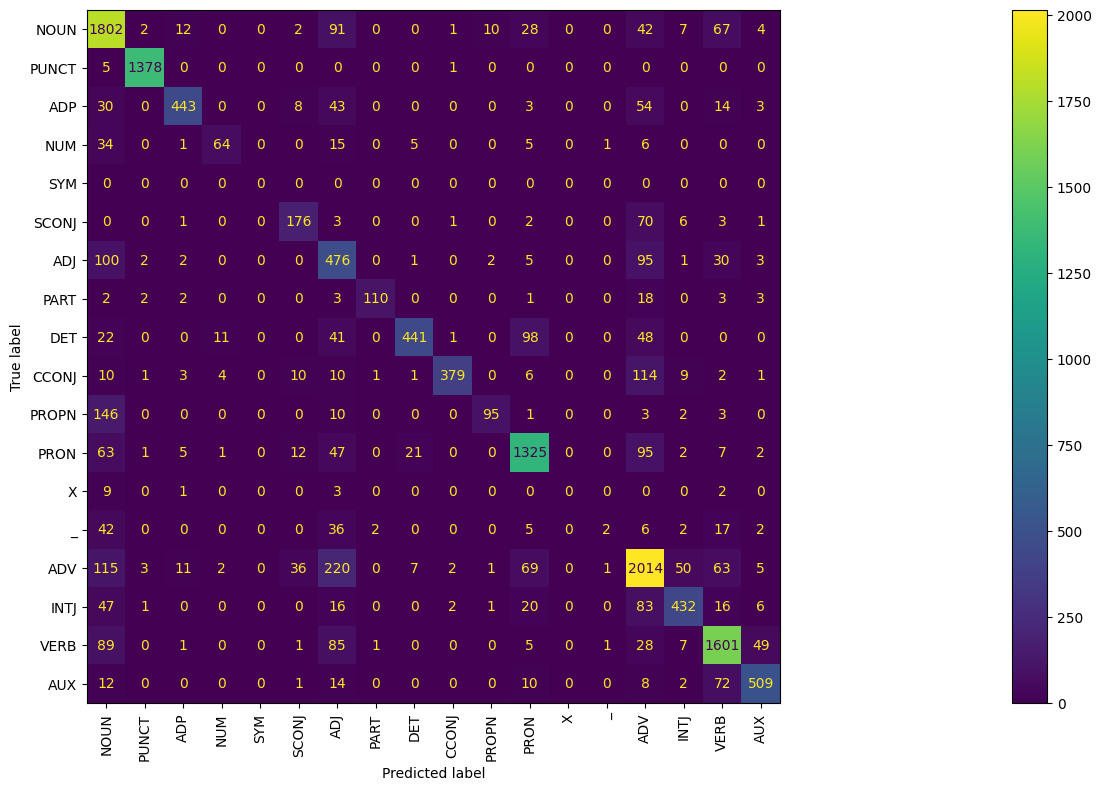

In [35]:
pred = save_metrics(
    pos_classes,
    test_pos_dl,
    clf_nn,
    task="upos",
    output=res_path,
    pad_token_id=tokenizer.pad_token_id
)

### Language Code Prediction
We also evaluate on the ability of predicting the language in our data set. There are 4 different classes: German, Turkish, Mixed (code-switching) and Other (such as punctuation)

Again, we load the data set.

In [16]:
train_code_dl, val_code_dl, test_code_dl = get_ud_data(
  ud_ds,
  batch_size=batch_size,
  tokenizer=tokenizer,
  label_type="lang-code")

Map:   0%|          | 0/285 [00:00<?, ? examples/s]

In [15]:
dim = model.config.hidden_size
code_classes = get_code_mapping() # Mapping from class label to index
num_classes = len(code_classes)


clf_nn = UpperBoundClassifier(num_classes, model, dim=dim)

# Train model.
logs = train_model(
clf_nn,
train_code_dl,
val_code_dl,
lr=lr,
n_epochs=n_epochs,
pad_token_id=tokenizer.pad_token_id
)

Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.76it/s]


Train Loss: 8.878639504313469	 Train Accuracy 0.8317815021725636
Val Loss: 13.332916110754013	 Val Accuracy 0.9282998783454988


Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.76it/s]


Train Loss: 3.1465124264359474	 Train Accuracy 0.9474446513552659
Val Loss: 11.163495741784573	 Val Accuracy 0.9343065693430657


Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.78it/s]


Train Loss: 2.3842439092695713	 Train Accuracy 0.957790192427064
Val Loss: 11.044641602784395	 Val Accuracy 0.9381082725060828


Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.72it/s]


Train Loss: 1.8400181792676449	 Train Accuracy 0.9656528036416304
Val Loss: 10.560199344530702	 Val Accuracy 0.9394768856447688


Validating...: 100%|██████████| 51/51 [00:08<00:00,  5.77it/s]

Train Loss: 1.4367740675807	 Train Accuracy 0.9739292364990689
Val Loss: 10.549631271511316	 Val Accuracy 0.9397810218978102


Predicting..: 100%|██████████| 51/51 [00:02<00:00, 19.43it/s]


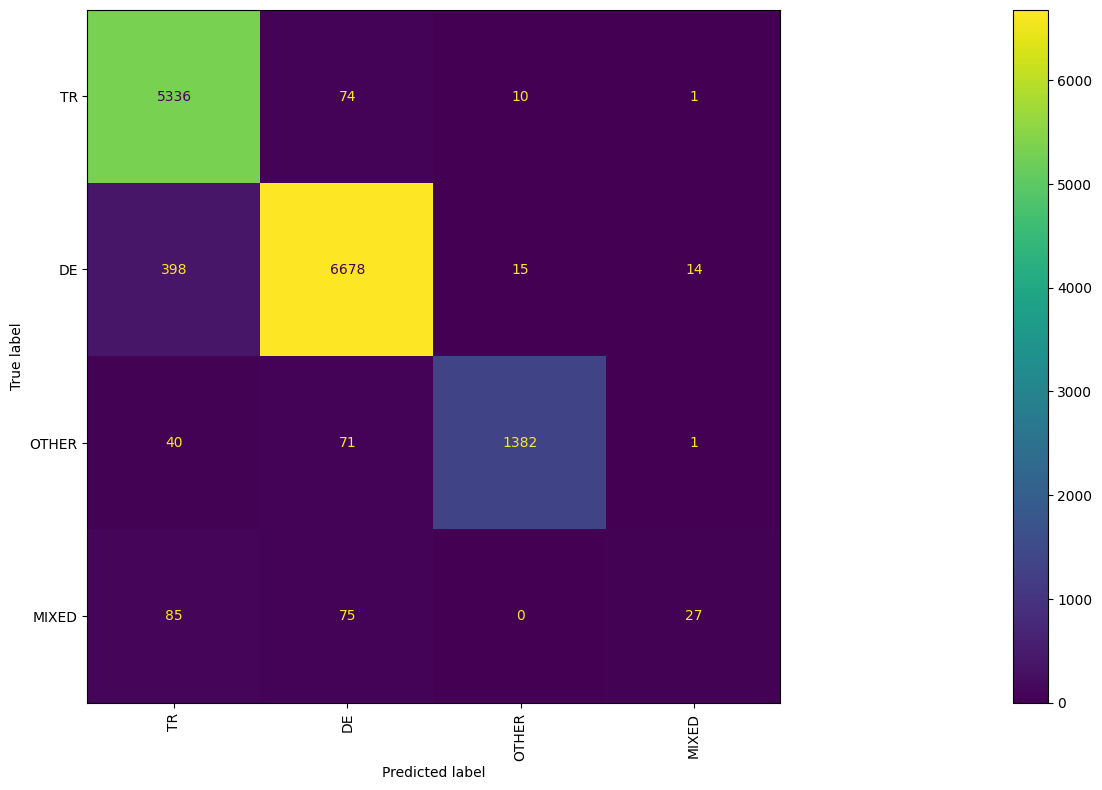

In [17]:
pred = save_metrics(
    code_classes,
    test_code_dl,
    clf_nn,
    task="lang-code",
    output=res_path,
    pad_token_id=tokenizer.pad_token_id
)

### Masked Token Prediction
We also evaluate how well a model can predict masked tokens. We take a sequence and mask each token once.

In [20]:
lm_model = AutoModelForMaskedLM.from_pretrained(model_type).to(device)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.p

In [22]:
train_dl, val_dl, test_dl = get_ud_data(ud_ds, batch_size=batch_size, tokenizer=tokenizer, label_type="mlm")

In [ ]:
accs3 = []
accs5 = []
accs1 = []
lm_model.eval()
for line in tqdm(test_dl.dataset, desc="Predicting masked tokens.."):
  text = line["text"]
  max_len = tokenizer.model_max_length
  mask_token_id = tokenizer.mask_token_id
  input_ids =  tokenizer(
        text,
        add_special_tokens=False,
        return_tensors="pt",
        max_length=max_len,
        truncation=True)["input_ids"]
  pred = predict_masked_bert(input_ids, lm_model, mask_token_id)
  acc1 = accuracy_at_n(y_true=input_ids, y_pred=pred, n=1)
  acc3 = accuracy_at_n(y_true=input_ids, y_pred=pred, n=3)
  acc5 = accuracy_at_n(y_true=input_ids, y_pred=pred, n=5)
  accs3.append(acc3.item())
  accs1.append(acc1.item())
  accs5.append(acc5.item())

acc_mlm = {
    "accuracy@1": mean(accs1),
    "accuracy@3": mean(accs3),
    "accuracy@5": mean(accs5)
}

In [29]:
print(acc_mlm)
mlm_path = os.path.join(res_path, "mlm-accuracy.json")
with open(mlm_path, "w", encoding="utf-8") as mlm_file:
    json.dump(acc_mlm, mlm_file)

{'accuracy@1': 0.9263029992950629, 'accuracy@3': 0.9309524525766787, 'accuracy@5': 0.9331357803403961}


## GURK Model

In [37]:
mld_path = "/content/drive/MyDrive/gurk_model/jan11-epoch0-step420000.pt"
cfg_path = "/content/GurkLM/configs/run-02-params.json"


In [39]:
with open(cfg_path, "r") as config_f: # Load file with hyperparameter configuration.
  params = json.load(config_f)

tokenizer = BertTokenizerFast.from_pretrained(params["tokenizer-model"])
data_tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [42]:
model = FullModel(
        vocab_size=tokenizer.vocab_size,
        max_len=params["max_len"],
        **params["model_params"]
    )
checkpoint = torch.load(mld_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>